In [1]:
import pickle
import pandas as pd
import plotly.express as px
from feature_engine.selection import DropCorrelatedFeatures

from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_evaluations, plot_convergence, plot_objective
from skopt.utils import dump, load

from utils.data_preparation import *
from utils.data_exploration import *
from utils.training import *

from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier


task = "CYP2C19"

## Loading the Dataset + Data Cleaning

In terms of data cleaning the following steps are performed:

- Normalization of smiles strings before calculating descriptors and fingerprints
  - Normalization includes the removal of metals in the molecule (<span style="color:cyan">TODO</span> Why?)
- Removal of small molecules
  - For example: 
    - Molecules consisting of a single atom (<span style="color:cyan">TODO</span> Why?)
    - Molecules that are metals
- *Molecular Descriptors:* Removing of NaN values by either removing the corresponding column or row. 
  - For molecular descriptors it doesn't make much sense to fill missing values with some default value or mean of the existing values


In the first iteration we will focus on using the Morgan fingerprints. If there is time later we will explore other fingerprints and compare. 

In [2]:
data = data_preprocessing(task)
data = data.drop(["MACCS_FP", "ATOMPAIR_FP"], axis=1)
data = select_druglike_molecules(data)
# data = remove_small_molecules(data)

# turn string of fingerprints into single features
morgan_fingerprint_df = pd.DataFrame(
    convert_strings_to_int_array(data["Morgan_FP"].values), index=data.index
)
data = data.merge(morgan_fingerprint_df, left_index=True, right_index=True)

data

Dataset already exists, returning data/cyp2c19/raw_dataset.csv.
Numbe of molecules before druglikeliness selection: 12665
Numbe of druglike molecules: 12210


,Y,Drug,Drug_ID,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1,6602638.0,11.609395,0.039701,11.609395,0.039701,0.906872,309.841,285.649,...,0,0,0,0,0,0,0,0,0,0
1,1,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,644675.0,12.610408,-3.973681,12.610408,0.072387,0.720977,355.418,346.346,...,0,0,0,0,0,0,0,0,0,0
2,1,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,644851.0,6.126257,0.660427,6.126257,0.660427,0.756902,255.708,245.628,...,0,0,0,0,0,0,0,0,0,0
3,1,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,644890.0,5.719940,-0.219974,5.719940,0.075509,0.605920,421.549,390.301,...,0,0,0,0,0,0,0,0,0,0
4,1,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,644968.0,12.040635,-0.208718,12.040635,0.006714,0.728361,324.344,308.216,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12660,0,CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C=C[C@@H]...,16758814.0,12.346902,-0.801800,12.346902,0.024123,0.682518,263.293,246.157,...,0,0,0,0,0,0,0,0,0,0
12661,0,O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...,16758816.0,13.390757,-1.019880,13.390757,0.162294,0.455270,397.427,374.243,...,0,0,0,0,0,0,0,0,0,0
12662,1,CCN1C(=O)[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@...,16758817.0,12.817440,-0.985371,12.817440,0.131139,0.406549,335.356,314.188,...,0,0,0,0,0,0,0,0,0,0
12663,0,C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...,16758818.0,13.179767,-1.161112,13.179767,0.077392,0.772281,357.406,334.222,...,0,0,0,0,0,0,0,0,0,0


### Remove missing values 
Since less than 1% of molecules have missing values we simply remove those molecules since using a default value doesn't make much sense for the shown descriptors.

In [3]:
data_nan = extract_null(data)
print(
    f"There are {data_nan.shape[0]} ({data_nan.shape[0]/data.shape[0]*100:.2f}%) molecules and {data_nan.shape[1]-3} descriptors with missing values."
)
data_nan

There are 35 (0.29%) molecules and 12 descriptors with missing values.


,Drug,Drug_ID,Y,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW
3855,O=[As](O)(O)c1ccc([As](=O)(O)O)cc1,224250.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3856,O=S(=O)(Nc1nccs1)c1ccc([As](=O)(O)O)cc1,224267.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3857,O=C(O)CNC(=O)c1ccc([As](=O)(O)O)cc1,224270.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3858,O=[As](O)(O)c1ccc(N=Nc2ccc(O)cc2)cc1,224279.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3859,NC(=O)c1ccc(C(=O)Nc2ccc([As](=O)(O)O)cc2)cc1,224295.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3863,NC(=O)Nc1cc([As](=O)(O)O)cc(I)c1O,224575.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3879,NS(=O)(=O)Cc1ccc([As](=O)(O)O)cc1,224907.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3880,O=C(O)[C@@H](O)c1ccc([As](=O)(O)O)cc1,3246047.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3881,O=S(=O)(NCCO)c1ccc([Sb](=O)(O)O)cc1,224913.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3882,O=C(O)/C=C\c1cccc([Sb](=O)(O)O)c1,5771529.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data = data.drop(data_nan.index)
data.shape

(12175, 2260)

### Train-Validation-Test split


In [5]:
# split data in train, val, test
datasets = dataset_split(data.drop(["Drug", "Drug_ID", "Morgan_FP"], axis=1))

Splitting the data into 70.00% training, 10.00% training, and 20.00% testing.


In [6]:
# The descriptors include discrete and continuous data, distinguished by their dtype.

feature_groups = get_feature_groups(datasets, morgan_fingerprint_df)

Unique Datatypes: {dtype('int64'), dtype('float64')}


## Dataset Exoploration

In [7]:
datasets["train"].describe()

,Y,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
count,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,...,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000
mean,0.461981,11.222147,-0.825236,11.222147,0.200832,0.629437,342.136913,322.791049,341.760127,126.033091,...,0.026520,0.011969,0.024290,0.019831,0.035672,0.029218,0.021591,0.014903,0.024055,0.015137
std,0.498582,2.693377,1.439234,2.693377,0.224219,0.174060,85.287027,81.294685,85.183894,31.633750,...,0.160684,0.108753,0.153957,0.139428,0.185483,0.168428,0.145353,0.121170,0.153230,0.122106
min,0.000000,0.000000,-7.603763,0.000000,0.000000,0.086171,17.031000,14.007000,17.026549,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,10.903072,-0.965024,10.903072,0.049009,0.501267,287.751000,270.226000,287.169202,106.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,12.236159,-0.372411,12.236159,0.125293,0.647325,342.348500,323.226000,342.009207,126.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,12.869220,-0.041564,12.869220,0.248257,0.776694,399.537250,378.256000,399.171183,146.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,17.398044,3.500000,17.398044,3.500000,0.946895,776.872000,765.784000,776.686700,292.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


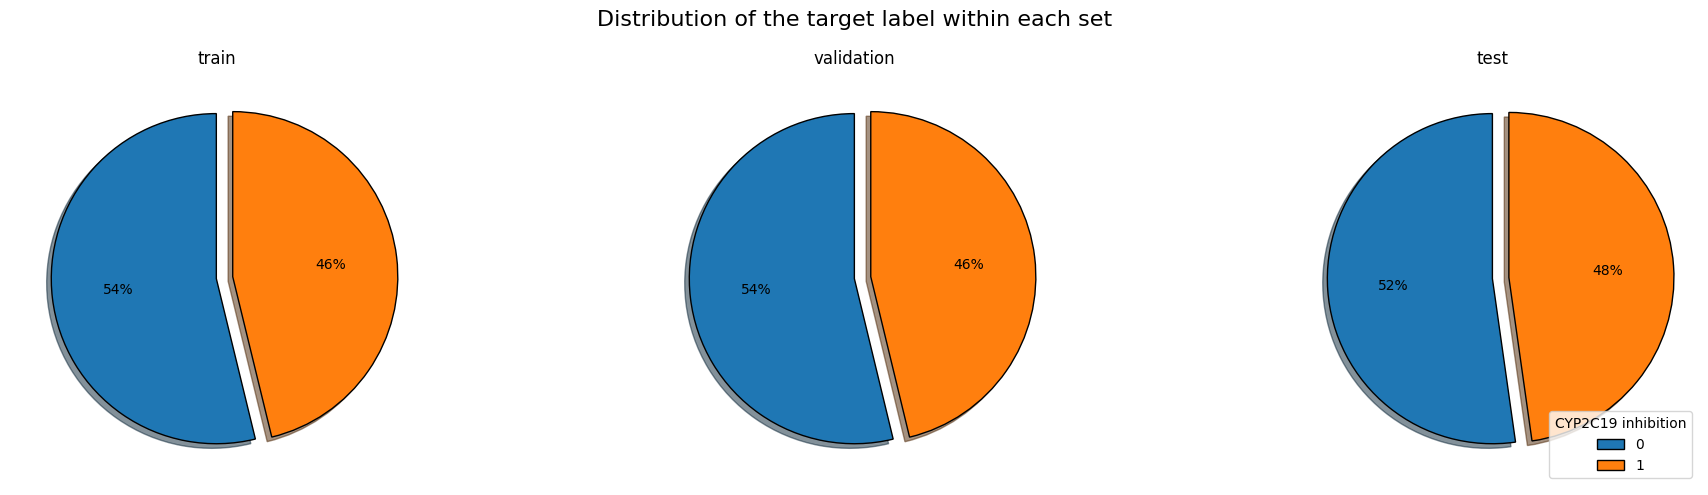

In [8]:
plot_counts(
    [datasets["train"]["Y"], datasets["val"]["Y"], datasets["test"]["Y"]],
    suptitle="Distribution of the target label within each set",
    titles=["train", "validation", "test"],
    legend_title="CYP2C19 inhibition",
    kind="pie",
)

### Continuous Data

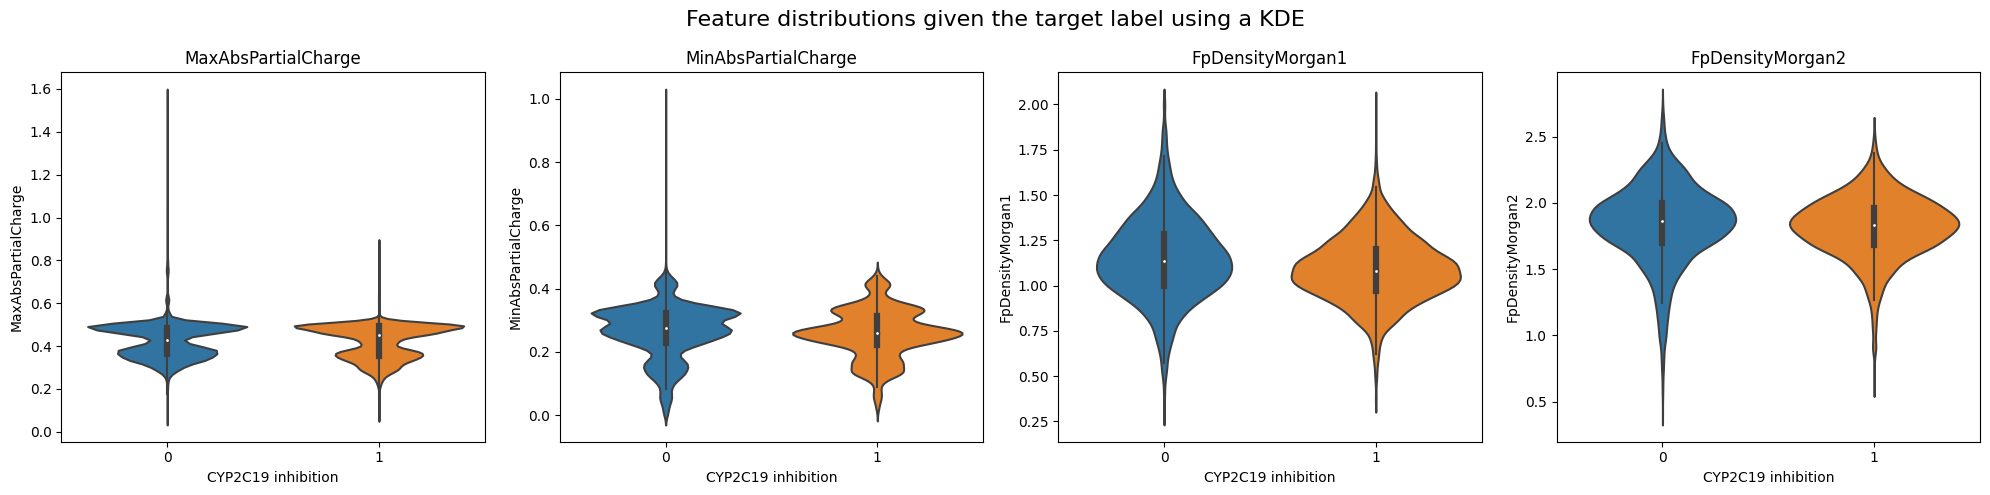

In [9]:
feature_distributions(
    data=datasets["train"][["Y"] + feature_groups.continuous],
    features=feature_groups.continuous[10:14],
    suptitle="Feature distributions given the target label using a KDE",
    task=f"{task} inhibition",
)

In [10]:
# Correlation matrix of descriptors
cor_matrix = datasets["train"][feature_groups.continuous].corr()
top_cor_matrix = cor_matrix.where(
    np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool)
)
fig = px.imshow(
    top_cor_matrix,
    color_continuous_scale="RdBu_r",
    title=f"{task} inhibition\nDescriptor correlation",
)

fig.write_html(f"data/{task.lower()}/descriptor_correlation.html")


### Discrete Data

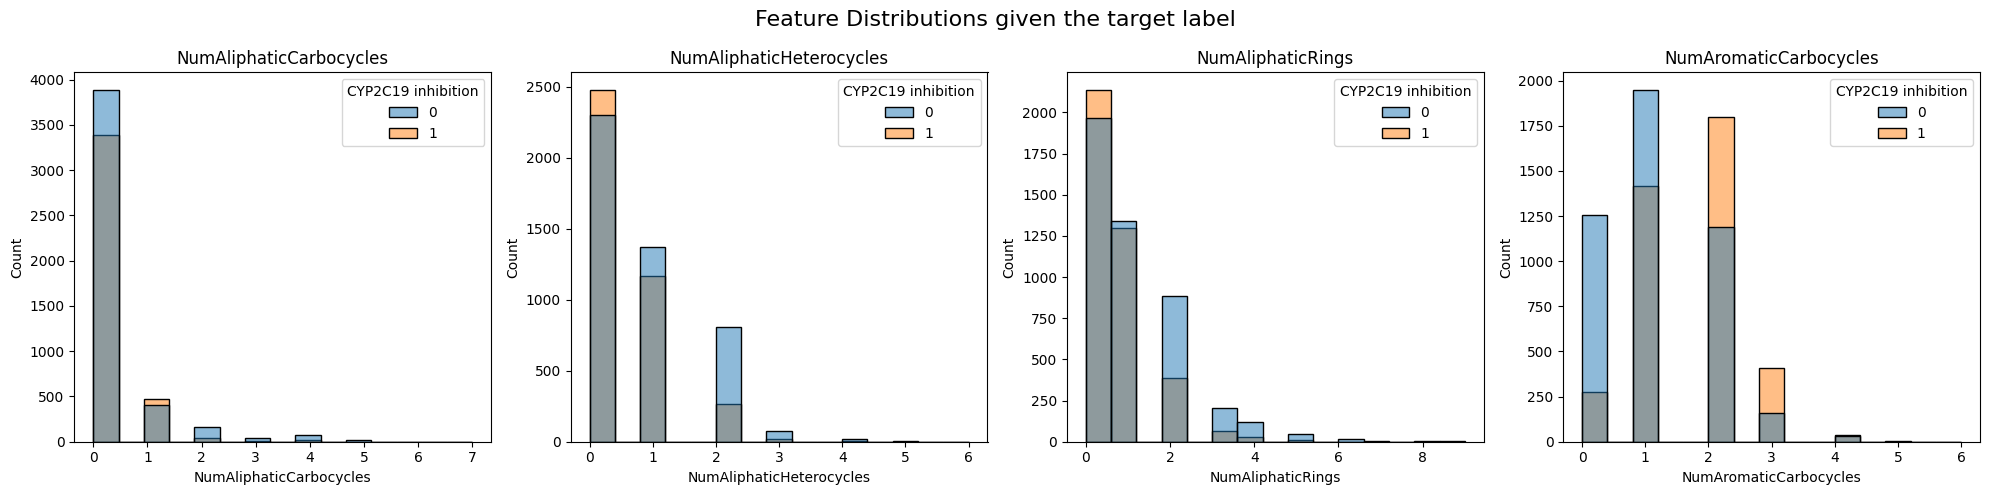

In [11]:
feature_distributions(
    data=datasets["train"][["Y"] + feature_groups.discrete],
    features=feature_groups.discrete[5:9],
    kind="hist",
    suptitle="Feature Distributions given the target label",
    task="CYP2C19 inhibition",
)


## Feature Selection

There are in total 208 different descriptors. Relevant descriptors for the task of predicting CYP inhibition need to be selected to reduce the number of input variables to the clasical machine learning algorithm. Feature selection can either be performed unsupervised (without knowledge of the target label) or supervised.

**Note:** Some machine learning models have some form of feature selection inbuild, e.g. tree-based models. In those cases we don't perform feature selection upfront.

### Variance Threshold

Having a look at for example the number of radical electrons (NumRadicalElectrons). We can see that all datapoints in the dataset have a value of 0 (min=max=0.0). 

In the area of feature selection there is a method called **variance threshold**: Given a threshold all features with a variance below this threshold will be removed. (<span style="color:cyan">TODO</span> Add better source; https://medium.com/nerd-for-tech/removing-constant-variables-feature-selection-463e2d6a30d9#:~:text=Variance%20Threshold%20is%20a%20feature,be%20used%20for%20unsupervised%20learning.)

The default value is usually 0 (removing constant features as they obviously bring no additional information to our model). If the variance threshold is greater than zero but still small we are removing quasi-constant features. The arguments against using a variance greater than 0 say that you may be moving variables that, although they have low variance, might actually be extremely powerful in explaining your target (dependent) variable.

For now, we are exploring which features are constant in our dataset.

In [12]:
print(summarize_descriptors(["NumRadicalElectrons"]))
datasets["train"]["NumRadicalElectrons"].describe()

{'NumRadicalElectrons': 'The number of radical electrons the molecule has (says nothing about spin state)'}


count    8522.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: NumRadicalElectrons, dtype: float64

In [13]:
print("Features with 0 variance:\n")
for index, n_unique in zip(
    datasets["train"].nunique(axis=0).index, datasets["train"].nunique(axis=0)
):
    if n_unique == 1:
        print(index)


Features with 0 variance:

NumRadicalElectrons
SMR_VSA8
SlogP_VSA9
fr_prisulfonamd


### Drop Correlated Features

As shown in the correlation matrix there are some feature groups in our dataset with high correlation. In order to escape the curse of dimensionality we want to remove features with a high correlation to other features - out of two features with high correlation only one remains. When features are collinear, permutating one feature will have little effect on the models performance because it can get the same information from a correlated feature. One way to handle multicollinear features is by performing hierarchical clustering on the Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster. Source: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

The y-axis of the following dendrogram is a measure of closeness of either individual data points or clusters. 


The idea of dropping highly correlated features is also applied by the following method: [DropCorrelatedFeatures](https://feature-engine.readthedocs.io/en/1.1.x/selection/DropCorrelatedFeatures.html) from the feature_engine. Here, features are removed on first found first removed basis, without any further insight using pearson correlation score.

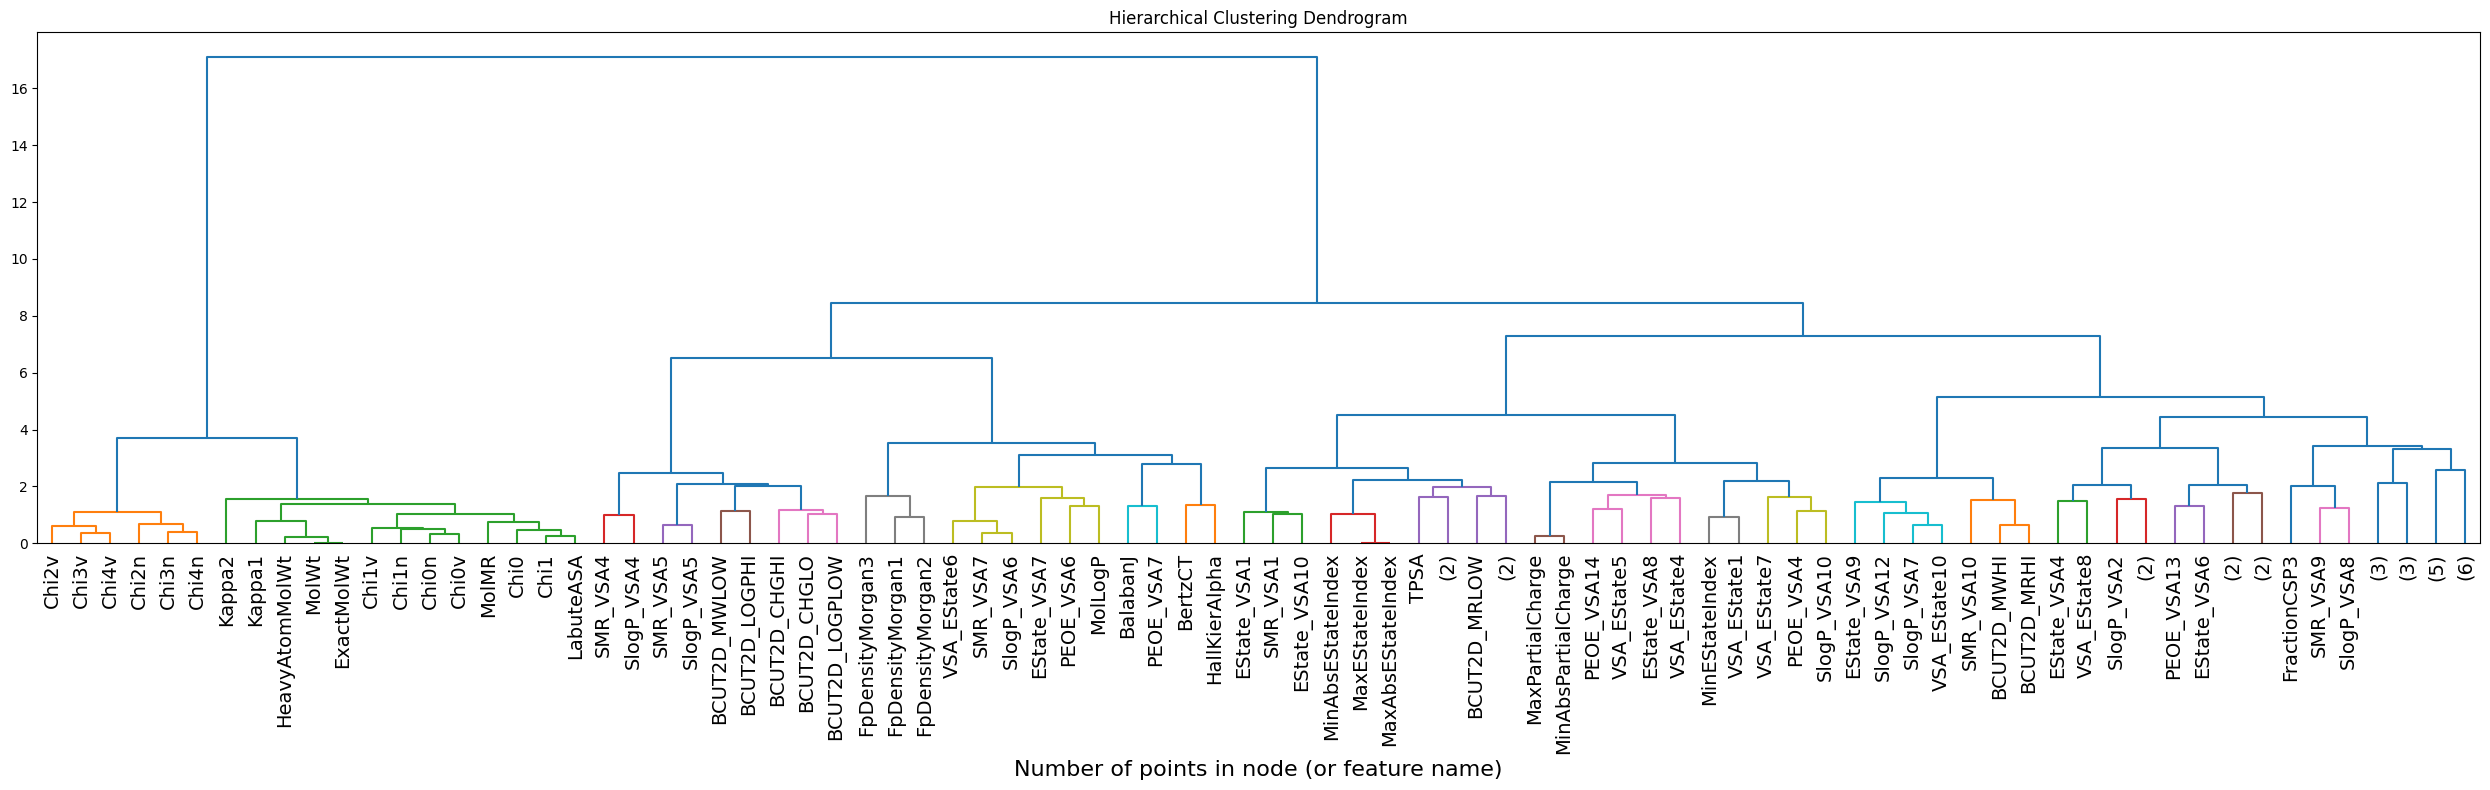

In [14]:
plot_dendrogram(cor_matrix, level=7, color_threshold=2)

In [15]:
# Exploring DropCorrelatedFeatures

drop_corr_features = DropCorrelatedFeatures(threshold=0.8)
print(
    "Number of features before transformation:",
    datasets["train"][feature_groups.continuous].shape[1],
)
reduced_continuous_data = drop_corr_features.fit_transform(
    datasets["train"][feature_groups.continuous]
)
print("Number of features after transformation:", reduced_continuous_data.shape[1])

# Correlation matrix of descriptors
reduced_cor_matrix = reduced_continuous_data.corr()
reduced_top_cor_matrix = reduced_cor_matrix.where(
    np.triu(np.ones(reduced_cor_matrix.shape), k=1).astype(np.bool)
)
fig = px.imshow(
    reduced_top_cor_matrix,
    color_continuous_scale="RdBu_r",
    title=f"{task} inhibition\nDescriptor correlation after dropping highly correlated features",
)

fig.write_html(f"data/{task.lower()}/descriptor_correlation_pruned.html")

Number of features before transformation: 104
Number of features after transformation: 76


### Select Percentile

For discrete features and fingerprints we are using a mutual information statistical test and apply multivariate feature selection.

## Dimensionality reduction

### PCA

For continuous data we will perform a PCA to reduce the dimensionality of the features. Since PCA should only be applied to continuous data we will split our preprocessing pipeline into three parts:

1. Preprocessing of continuous descriptors
2. Preprocessing of discrete descriptors
3. Preprocessing of the fingerprint

See DataPreprocessing in utils/training.py for the exact preprocessing pipelines.

## Feature Normalization

For continuous features we are using StandardScaler as this is assumed by PCA. For discrete descriptors we are using a MinMaxScaler. Since fingerprint features are binary we don't normalize them.

## Training

### Dummy Classifier

Accuracy: 53.78%


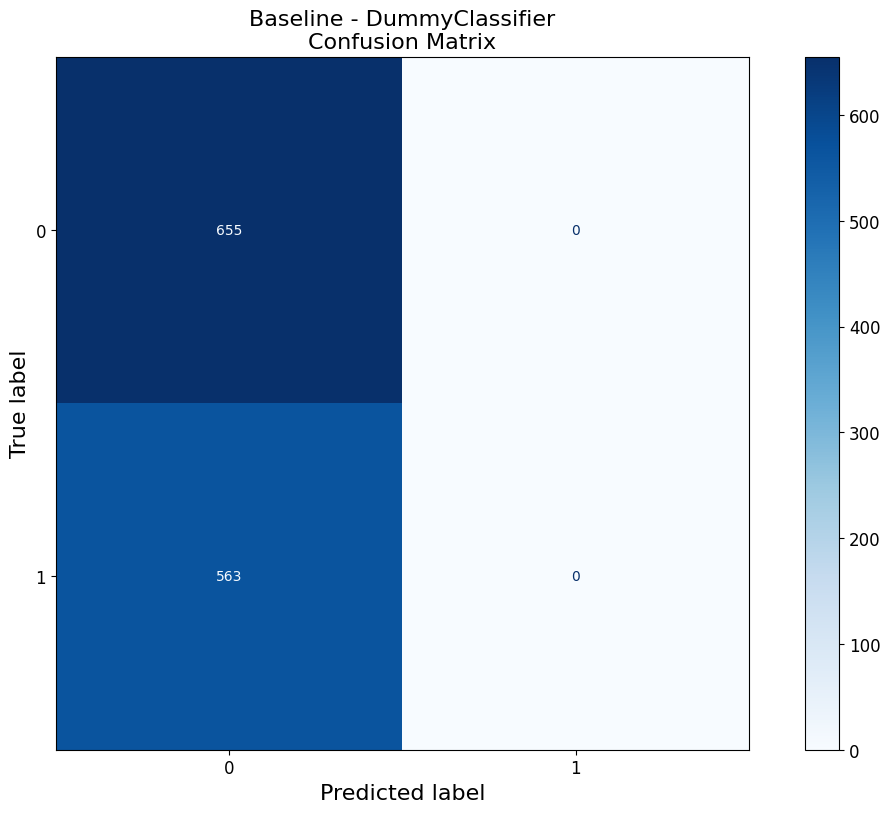

In [16]:
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(datasets["train"].drop("Y", axis=1), datasets["train"]["Y"])
y_pred_baseline = baseline.predict(datasets["val"].drop("Y", axis=1))

plot_confusion_matrix(datasets["val"]["Y"], y_pred_baseline, "Baseline - DummyClassifier")

### SVC

To keep track of old Bayesian Optimization runs and their differences:

#### SVC_bayesian_0


In [17]:
svc_bayesian_optimizer = BayesianOptimization(
    model=SVC,
    file_name="svc_bayesian_0", 
    model_params=[
        Real(name="C", low=0.1, high=4.0)
    ],
    datasets=datasets,
    feature_groups=feature_groups,
)

svc_results = svc_bayesian_optimizer.optimize() 

# LOAD results from bayesian optimization
# results = pd.read_csv("optimization/svc_bayesian_0")

svc_results

Iteration No: 1 started. Evaluating function at random point.
Number of features after preprocessing:             734/2256
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 27.6286
Function value obtained: -0.8120
Current minimum: -0.8120
Iteration No: 2 started. Evaluating function at random point.
Number of features after preprocessing:             347/2256
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 15.0289
Function value obtained: -0.7972
Current minimum: -0.8120
Iteration No: 3 started. Evaluating function at random point.
Number of features after preprocessing:             2156/2256
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 66.5383
Function value obtained: -0.8243
Current minimum: -0.8243
Iteration No: 4 started. Evaluating function at random point.
Number of features after preprocessing:             392/2256
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 16.9877
Function value obtained: -0.8

,C,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy
0,2.295234,0.022710,0.030248,0.027170,0.777364,-0.811987
1,0.835014,0.008464,0.046321,0.049733,0.826599,-0.797209
2,1.138431,0.008248,0.045341,0.008996,0.784090,-0.824302
3,3.615912,0.008186,0.009095,0.046249,0.834662,-0.818555
4,2.441056,0.042489,0.012432,0.037263,0.750556,-0.822660
5,3.197492,0.035940,0.031203,0.047750,0.754386,-0.811987
6,0.658507,0.006097,0.001503,0.006173,0.773300,-0.821018
7,2.896199,0.044559,0.021082,0.019039,0.925913,-0.816092
8,3.385190,0.029951,0.001011,0.042962,0.789223,-0.820197
9,2.621635,0.032128,0.026591,0.045665,0.702513,-0.813629


Number of features after preprocessing:             2198/2256
Accuracy: 83.00%


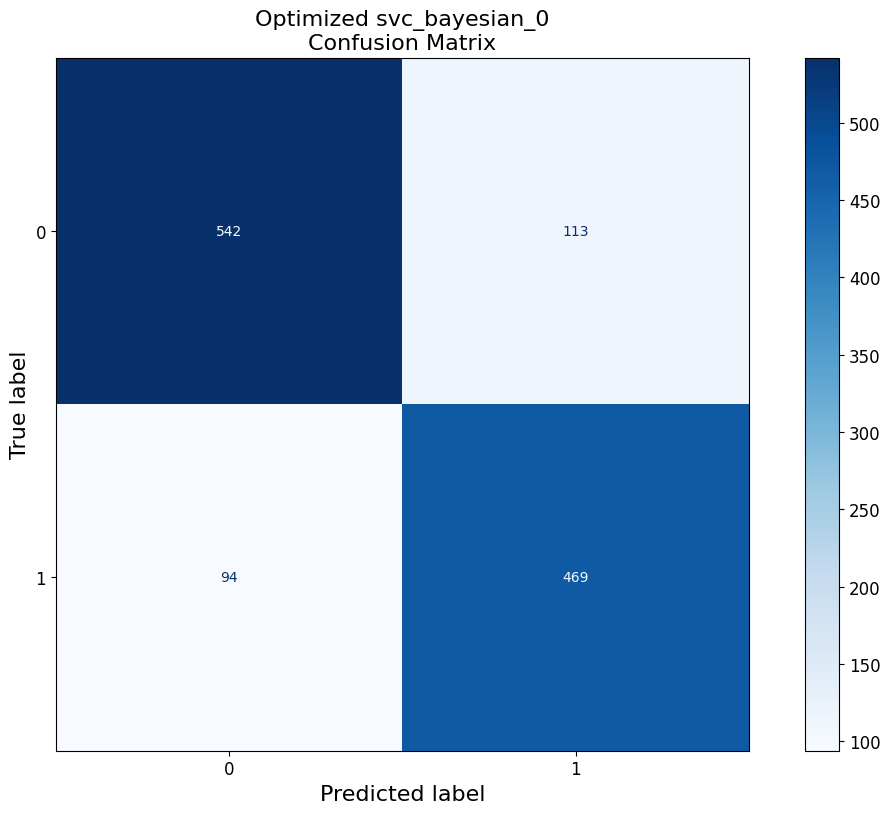

In [18]:
svc_bayesian_optimizer.best_confusion_matrix(svc_results)

#### svc_random_0

In [19]:
svc_bayesian_optimizer = BayesianOptimization(
    model=SVC,
    file_name="svc_random_0", 
    model_params=[
        Real(name="C", low=0.1, high=4.0),
    ],
    datasets=datasets,
    feature_groups=feature_groups,
)

# results = svc_bayesian_optimizer.optimize(n_calls=50, n_initial_points=50) 

# LOAD results from bayesian optimization
# results = load("optimization/svc_bayesian_0")

# svc_bayesian_optimizer.best_confusion_matrix(results)

### RandomForestClassifier

For a random forest classifier we don't need to do any preprocessing. A decision tree based classifier is scale variant and has inbuild feature selection.

#### max_depth

turn following cell into python to re-run / edit

In [20]:
max_depths = [depth for depth in range(3, 70)]
metric_values = []
x_train = np.array(datasets["train"].drop("Y", axis=1))
y_train = np.array(datasets["train"]["Y"])
x_val = np.array(datasets["val"].drop("Y", axis=1))
y_val = np.array(datasets["val"]["Y"])

with open("optimization/rf_max_depth", "w") as f:
    f.write(f", max_depth, val_accuracy\n")
    for idx, max_depth in enumerate(max_depths):
        rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_val)
        acc = accuracy_score(y_val, y_pred)
        print(
            f"Completed run {idx}/{len(max_depths)}: max_depth={max_depth}, accuracy={acc}"
        )
        metric_values.append(acc)
        f.write(f"{idx}, {max_depth}, {acc}\n")

# load results
rf_results = pd.read_csv("optimization/rf_max_depth")
rf_results

Completed run 0/67: max_depth=3, accuracy=0.7430213464696224
Completed run 1/67: max_depth=4, accuracy=0.7536945812807881
Completed run 2/67: max_depth=5, accuracy=0.7635467980295566
Completed run 3/67: max_depth=6, accuracy=0.7684729064039408
Completed run 4/67: max_depth=7, accuracy=0.7758620689655172
Completed run 5/67: max_depth=8, accuracy=0.7824302134646962
Completed run 6/67: max_depth=9, accuracy=0.7824302134646962
Completed run 7/67: max_depth=10, accuracy=0.7931034482758621
Completed run 8/67: max_depth=11, accuracy=0.7898193760262726
Completed run 9/67: max_depth=12, accuracy=0.7939244663382594
Completed run 10/67: max_depth=13, accuracy=0.7881773399014779
Completed run 11/67: max_depth=14, accuracy=0.7980295566502463
Completed run 12/67: max_depth=15, accuracy=0.80623973727422
Completed run 13/67: max_depth=16, accuracy=0.7963875205254516
Completed run 14/67: max_depth=17, accuracy=0.8029556650246306
Completed run 15/67: max_depth=18, accuracy=0.8070607553366174
Completed r

,Unnamed: 0,max_depth,val_accuracy
0,0,3,0.743021
1,1,4,0.753695
2,2,5,0.763547
3,3,6,0.768473
4,4,7,0.775862
...,...,...,...
62,62,65,0.812808
63,63,66,0.804598
64,64,67,0.810345
65,65,68,0.801314


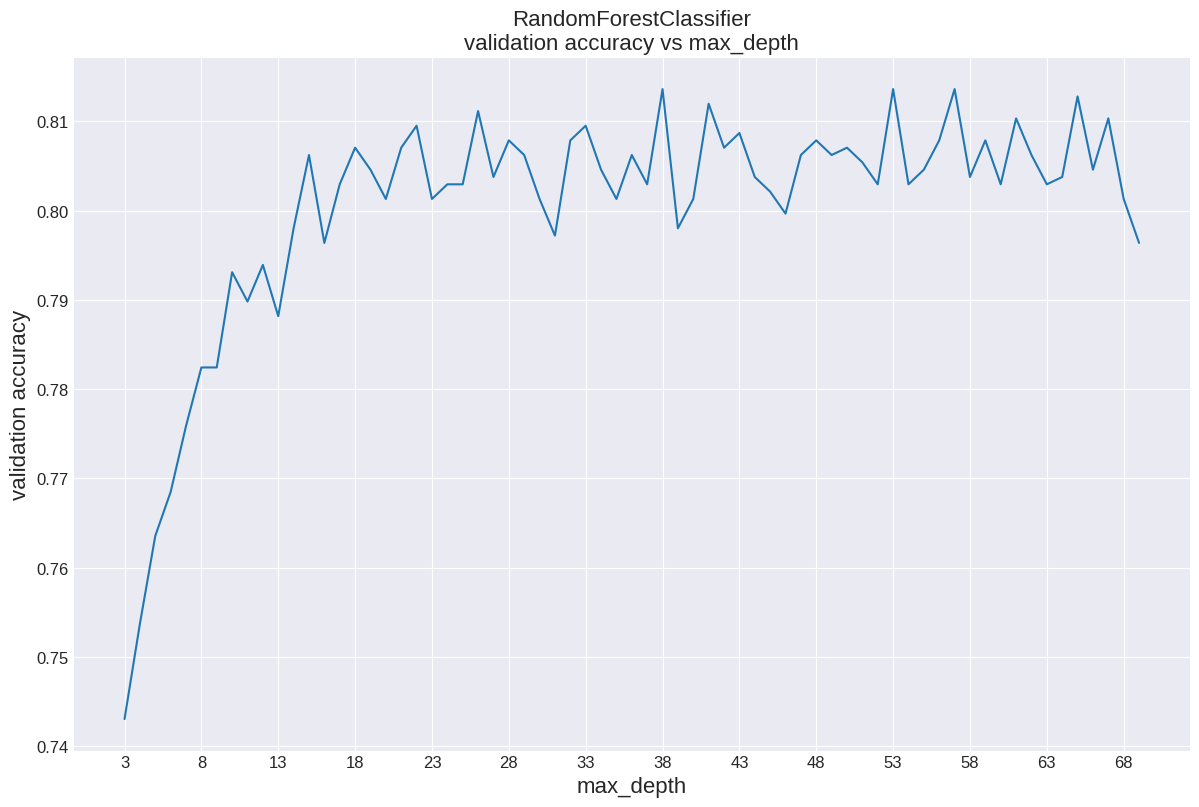

In [25]:
plot_parameter_metric(
    metric_values=rf_results[" val_accuracy"],
    model_name="RandomForestClassifier",
    metric="validation accuracy",
    parameter="max_depth",
    param_values=rf_results[" max_depth"],
)

Accuracy: 80.87%


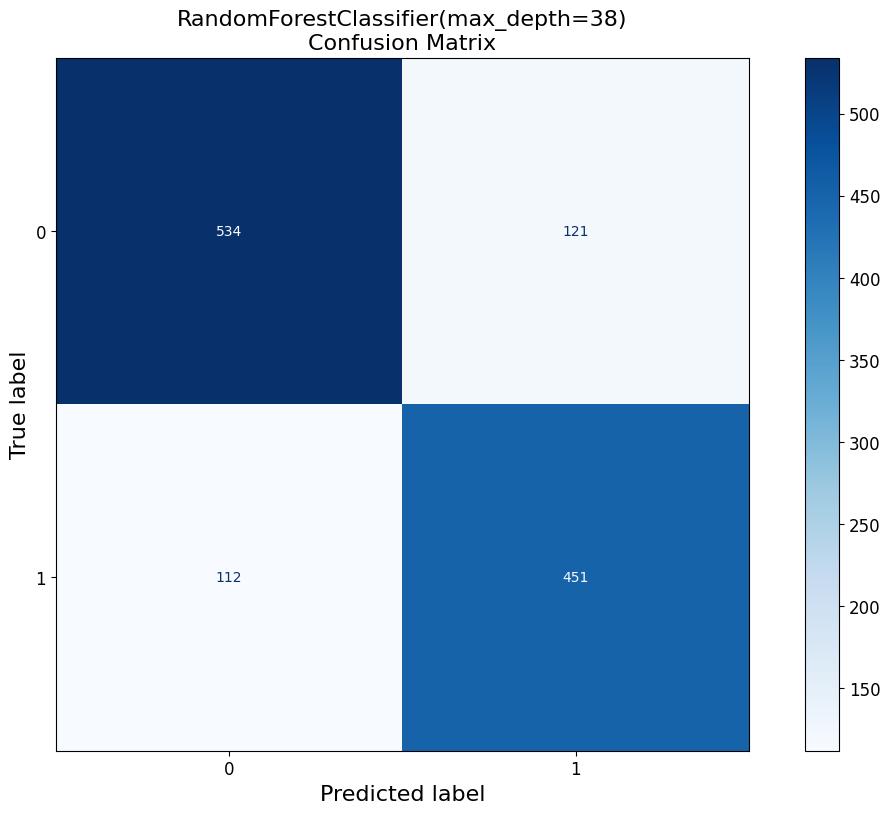

In [27]:
x_train = np.array(datasets["train"].drop("Y", axis=1))
y_train = np.array(datasets["train"]["Y"])
x_val = np.array(datasets["val"].drop("Y", axis=1))
y_val = np.array(datasets["val"]["Y"])

best_rf = RandomForestClassifier(max_depth = 38, n_jobs=-1)
best_rf.fit(x_train, y_train)
y_pred = best_rf.predict(x_val)
plot_confusion_matrix(y_val, y_pred, "RandomForestClassifier(max_depth=38)")


### Logistic Regression

#### lr_bayesian_0

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_bayesian_optimizer = BayesianOptimization(
    model=LogisticRegression,
    file_name="lr_bayesian_0", 
    model_params=[
        Categorical(name="penalty", categories=["l1", "l2"]),
        Real(name="C", low=0.1, high=4.0),
        Categorical(name="solver", categories=["saga"]),
        Categorical(name="n_jobs", categories=[-1])
    ],
    datasets=datasets,
    feature_groups=feature_groups,
)
 
lr_results = lr_bayesian_optimizer.optimize() 
lr_results

Space([Categorical(categories=('l1', 'l2'), prior=None),
       Real(low=0.1, high=4.0, prior='uniform', transform='identity'),
       Categorical(categories=('saga',), prior=None),
       Categorical(categories=(-1,), prior=None),
       Real(low=0.0, high=0.05, prior='uniform', transform='identity'),
       Real(low=0.0, high=0.05, prior='uniform', transform='identity'),
       Real(low=0.0, high=0.05, prior='uniform', transform='identity'),
       Real(low=0.7, high=0.95, prior='uniform', transform='identity')])

In [ ]:
lr_bayesian_optimizer.best_confusion_matrix(lr_results)

# Next Steps

- ~~Use Dendrogram [only continuous data] for feature selection (Jonna)~~
- Feature selection method for discrete data (James)
- ~~Baseline~~
  - ~~DummyClassifier~~
- Classical models
  - ~~Random Forest (little feature selection) (Jonna)~~
  - KNN + Bayesian Optimization (James)
  - XGBoost + Bayesian Optimization (James)
  - ~~SVC (Jonna)~~
  - Linear Models (Jonna)
  - Naive Bayes + Bayesian Optimization (James)
  - [later] simple NN
- Try giving weights to classes (will solve unbalanced data sets) (James)"
- Get report working (James)
- ~~Bayesian Optimization (Jonna)~~